In [1]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

import os
#change to desired path
os.chdir("./drive/MyDrive/Research")
%pwd

Mounted at /content/drive


'/content/drive/MyDrive/Research'

In [2]:
%pip install torch datasets transformers tqdm matplotlib datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 12.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [3]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2TokenizerFast
from utils import setup_logging, CfgNode as CN
from trainer import Trainer
from model import GPT
from datasets import load_dataset
import numpy as np

In [4]:
def download_and_tokenize(dataset_name, split, tokenizer, data_dir):
    os.makedirs(data_dir, exist_ok=True)
    filename = os.path.join(data_dir, f"{dataset_name.split('/')[1]}_tokens.bin")
    if os.path.exists(filename):
        print(f"{filename} already exists, skipping download and tokenization...")
        return filename

    dataset = load_dataset(dataset_name, split=split, trust_remote_code=True)
    texts = dataset['text']
    tokens_np = []
    for text in tqdm(texts):
        tokens = tokenizer.encode(text)
        tokens_np.extend(tokens)

    tokens_np = np.array(tokens_np, dtype=np.int32)
    with open(filename, "wb") as f:
        f.write(tokens_np.tobytes())
    print(f"Saved {len(tokens_np)} tokens to {filename}")

    return filename

In [5]:
class WebTextDataset(Dataset):
    def __init__(self, token_file, block_size):
        self.token_array = np.fromfile(token_file, dtype=np.int32)
        self.block_size = block_size

    def __len__(self):
        return len(self.token_array) - self.block_size

    def __getitem__(self, idx):
        x = torch.tensor(self.token_array[idx:idx + self.block_size], dtype=torch.long)
        y = torch.tensor(self.token_array[idx + 1:idx + self.block_size + 1], dtype=torch.long)
        return x, y

In [6]:
def run_training(trainer, total_iters, early_stop_threshold):
    pbar = tqdm(total=total_iters, desc="Training progress", leave=True)
    train_losses = []
    best_loss = float('inf')
    no_improve_count = 0

    def update_progress(trainer):
        pbar.update(1)
        current_loss = trainer.loss.item()
        train_losses.append(current_loss)
        pbar.set_postfix_str(f"Loss: {current_loss:.4f}")

        nonlocal best_loss, no_improve_count
        if current_loss < best_loss:
            best_loss = current_loss
            no_improve_count = 0
        else:
            no_improve_count += 1
        if no_improve_count >= early_stop_threshold:
            pbar.close()
            raise StopIteration("Early stopping triggered")

    trainer.add_callback('on_batch_end', update_progress)

    try:
        trainer.run()
    except StopIteration as e:
        print(str(e))
    finally:
        try:
            pbar.close()
        except:
            pass

    return train_losses


In [21]:
C = CN()
C.system = CN()
C.system.work_dir = './out'
setup_logging(C)

C.model = GPT.get_default_config()
C.model.model_type = 'gpt-nano'
C.model.vocab_size = 50257
C.model.block_size = 256

C.trainer = Trainer.get_default_config()
#C.trainer.learning_rate = 5e-4
C.trainer.max_iters = 10000

model_path = os.path.join(C.system.work_dir, 'model.pt')
early_stop_threshold = 100
data_dir = './data'

In [15]:
model = GPT(C.model)

number of parameters: 3.25M


In [16]:
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [17]:
token_file = download_and_tokenize("Skylion007/openwebtext", 'train[:1%]', tokenizer, data_dir)
train_dataset = WebTextDataset(token_file, C.model.block_size)
trainer = Trainer(C.trainer, model, train_dataset)
losses = run_training(trainer, C.trainer.max_iters, early_stop_threshold)

./data/openwebtext_tokens.bin already exists, skipping download and tokenization...
running on device cuda


Training progress:  14%|█▎        | 1372/10000 [05:43<36:02,  3.99it/s, Loss: 6.4094]

Early stopping triggered


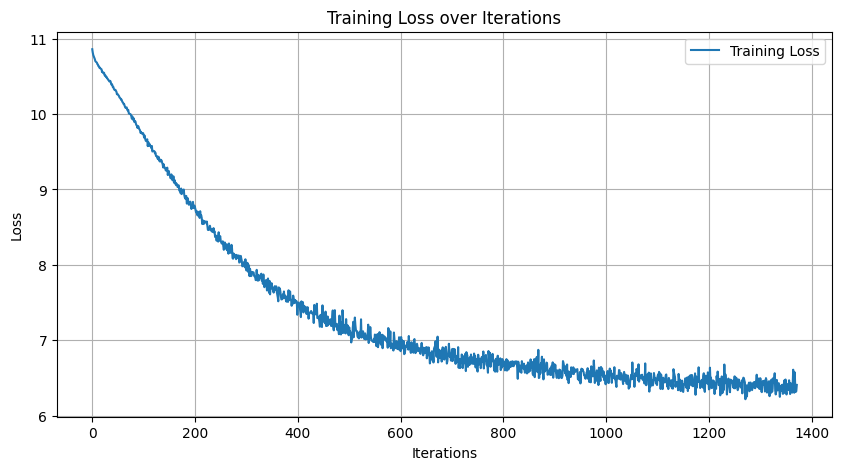

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.title('Training Loss over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to ./out/model.pt


In [22]:
model = GPT(C.model)
model.load_state_dict(torch.load(model_path))
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
model.eval()
input_phrase = "Yesterday"
input_ids = tokenizer.encode(input_phrase, return_tensors='pt')

with torch.no_grad():
    output = model.generate(input_ids, max_new_tokens=100, temperature=1, do_sample=True)

generated_text = tokenizer.decode(output[0])
print(f"Generated text: {generated_text}")

number of parameters: 3.25M
Generated text: Yesterday or lower entrance-4 into CB (ues comics.

 Subas (50, perpetrators was me into the Gear traffic) in their society. The work in the father

 feed on the dubious sign for America into the territorial hit recognition, independent EuropeanNext, full Clinton, the best winner on the Eartht really will tolerance in his bacter patentAtthips was not over the situation the Of New [9 Romeo manager,�What when the physical Prime on northern cool Drawi SWAT chBO
